<a href="https://colab.research.google.com/github/gerard08/ProjecteVC/blob/master/IntentUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install unrar
!unrar x /content/drive/MyDrive/VC/imagesVC.rar > /dev/null

In [7]:
import pandas as pd
import re
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
Pnm = '/content/allImagesNoMask/train/'#'C:/Users/ger-m/Desktop/UNI/3r/Visio/projecte/imagesVC/allImagesNoMask/train/'
Pm = '/content/allImagesMask/train/'#'C:/Users/ger-m/Desktop/UNI/3r/Visio/projecte/imagesVC/allImagesMask/train/'
#Pf = 'C:/Users/ger-m/Desktop/UNI/3r/Visio/projecte/imagesVC/Dataset/'

In [9]:
nmaskl = []
maskl = []
filtl = []
for el in os.listdir(Pnm):
    nmaskl.append(Pnm + el)
    name = re.sub('.jpg','', el)
    maskl.append(Pm + name + '-with-mask.jpg')
    #filtl.append(Pf + name + '_filter.jpg') 

list_of_tuples = list(zip(nmaskl, maskl))#, filtl)) 

df = pd.DataFrame(list_of_tuples,
                  columns = ['NoMask', 'Mask'])#, 'Filter']) 
     
df 
    

,NoMask,Mask
0,/content/allImagesNoMask/train/1803151818-0002...,/content/allImagesMask/train/1803151818-000222...
1,/content/allImagesNoMask/train/1803191139-0000...,/content/allImagesMask/train/1803191139-000009...
2,/content/allImagesNoMask/train/1803151818-0000...,/content/allImagesMask/train/1803151818-000072...
3,/content/allImagesNoMask/train/1803151818-0001...,/content/allImagesMask/train/1803151818-000192...
4,/content/allImagesNoMask/train/1803151818-0001...,/content/allImagesMask/train/1803151818-000133...
...,...,...
11366,/content/allImagesNoMask/train/1803191139-0000...,/content/allImagesMask/train/1803191139-000002...
11367,/content/allImagesNoMask/train/1803151818-0000...,/content/allImagesMask/train/1803151818-000097...
11368,/content/allImagesNoMask/train/1803151818-0001...,/content/allImagesMask/train/1803151818-000153...
11369,/content/allImagesNoMask/train/1803151818-0001...,/content/allImagesMask/train/1803151818-000191...


In [10]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=57, dim=(128, 128), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):      
      X_batch[i,] = self.X[idx]/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

In [11]:
def preprocessImages(image, size):
    im = cv2.imread(image)
    im = cv2.copyMakeBorder(im, 0, 0, 100, 100, cv2.BORDER_CONSTANT)
    tamany = (size, size)
    im = cv2.resize(im, tamany)
    return im

In [12]:
size = 128
masked = []
nmasked = []
l = len(df['NoMask'])
div = int(l/4)
for i, el in enumerate(df['NoMask']):
    print(str("{:.2f}".format((i/l)*100)) + ' % completat', end = '\r')
    nmasked.append(preprocessImages(el, size))
    masked.append(preprocessImages(df['Mask'][i], size))

trainData = createAugment(masked[:div], nmasked[:div])
testData = createAugment(masked[div:], nmasked[div:])
print('fet!')

fet!


In [13]:
trainData = createAugment(masked[:div], nmasked[:div])
testData = createAugment(masked[div:], nmasked[div:])

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [15]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(512, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(1024, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(2048, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(1024, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(512, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(256, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

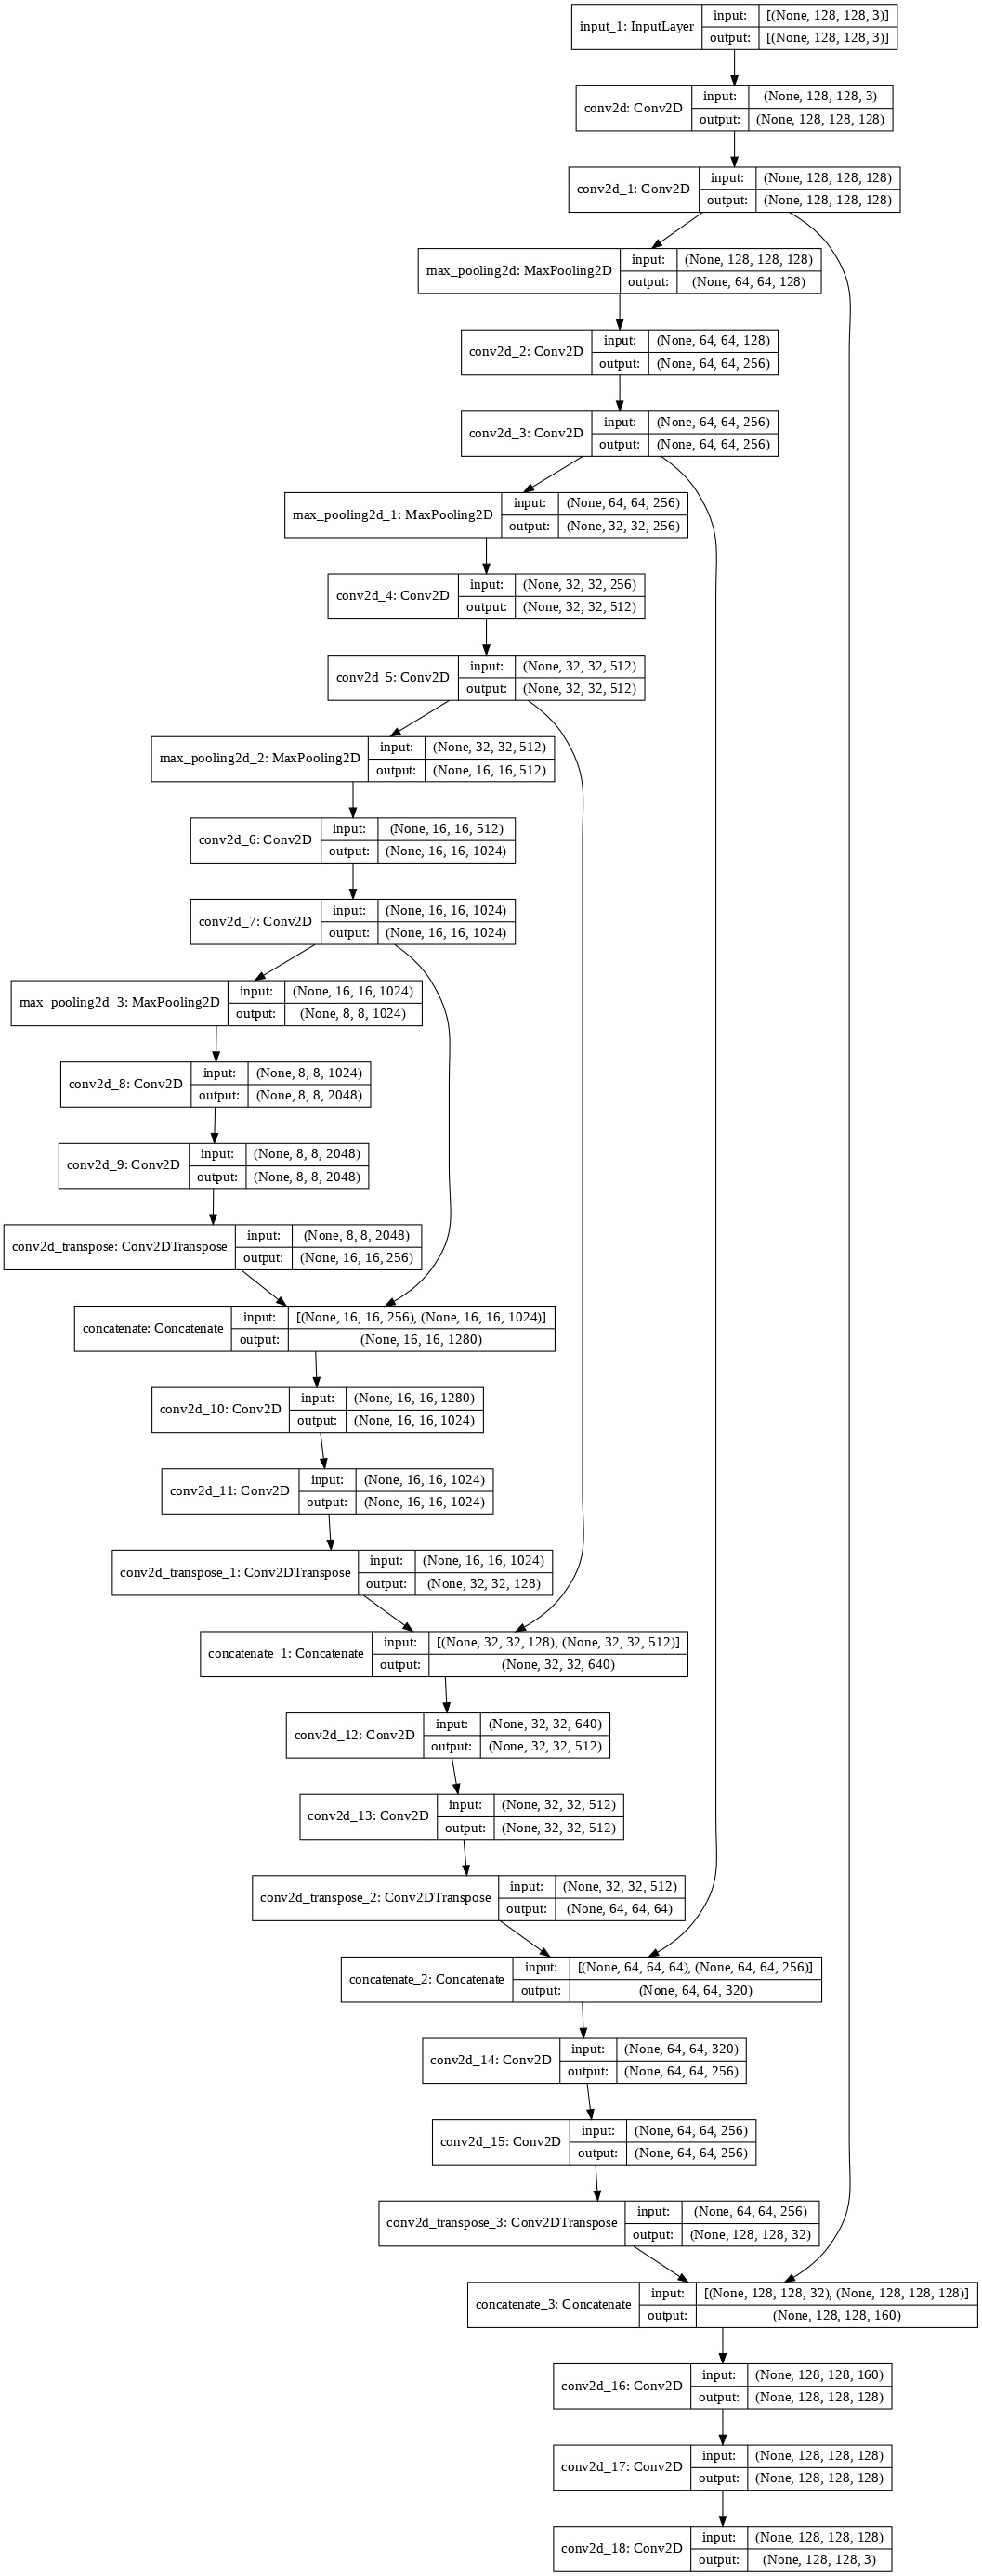

In [16]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [17]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_images, sample_labels = testgen[25]  
        
        inpainted_image = self.model.predict(np.expand_dims(sample_images[i], axis=0))

        plt.figure()

        f, axarr = plt.subplots(1,3) 

        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        axarr[0].imshow(sample_images, vmin=0, vmax=1)
        axarr[1].imshow(sample_labels, vmin=0, vmax=1)
        axarr[2].imshow(inpainted_image)


In [18]:

_ = model.fit(trainData, 
          validation_data=testData, 
          epochs=20, 
          steps_per_epoch=len(trainData), 
          validation_steps=len(testData),
          use_multiprocessing=True)
          #callbacks=[PredictionLogger()])

Epoch 1/20
49/49 [==============================] - 225s 3s/step - loss: 0.1196 - dice_coef: 0.6009 - val_loss: 0.0536 - val_dice_coef: 0.6518
Epoch 2/20
49/49 [==============================] - 158s 3s/step - loss: 0.0517 - dice_coef: 0.6537 - val_loss: 0.0543 - val_dice_coef: 0.6724
Epoch 3/20
49/49 [==============================] - 161s 3s/step - loss: 0.0454 - dice_coef: 0.6578 - val_loss: 0.0382 - val_dice_coef: 0.6533
Epoch 4/20
49/49 [==============================] - 161s 3s/step - loss: 0.0376 - dice_coef: 0.6607 - val_loss: 0.0380 - val_dice_coef: 0.6494
Epoch 5/20
49/49 [==============================] - 160s 3s/step - loss: 0.0345 - dice_coef: 0.6620 - val_loss: 0.0302 - val_dice_coef: 0.6617
Epoch 6/20
49/49 [==============================] - 160s 3s/step - loss: 0.0649 - dice_coef: 0.6314 - val_loss: 0.1504 - val_dice_coef: 0.6528
Epoch 7/20
49/49 [==============================] - 154s 3s/step - loss: 0.0576 - dice_coef: 0.6463 - val_loss: 0.0351 - val_dice_coef: 0.6672

In [19]:
model.save('/drive/MyDrive/MaskModel.h5')

In [27]:
m = masked[0].reshape((1,)+masked[i].shape)

In [36]:
inpainted_image = model.predict(m)

In [37]:
inpainted_image.shape

(1, 128, 128, 3)

<Figure size 432x288 with 0 Axes>

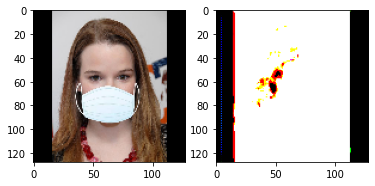

In [45]:
import matplotlib.pyplot as plt

plt.figure()

f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(cv2.cvtColor(masked[20], cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(inpainted_image[0,:], cv2.COLOR_BGR2RGB))


In [ ]:
plt.imshow(masked[4])

In [ ]:
plt.imshow(nmasked[4])